In [32]:
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
from sklearn.decomposition import PCA
import torch
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


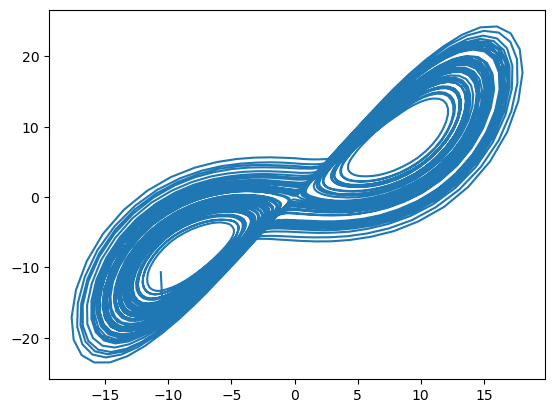

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from dysts.flows import Lorenz, Hadley

## Load and simulate an attractor
model = Lorenz()
sol = model.make_trajectory(5000, resample=True,noise=0.01)
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])


In [3]:
#try official implementation of s4?
import sys
sys.path.append("/om2/user/ostrow/NN_delay_embeddings/s4")
from models.s4.s4 import S4Block as S4  # Can use full version instead of minimal S4D standalone below
from models.s4.s4d import S4D


CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [5]:
from src.models.nn import DropoutNd
from einops import rearrange, repeat
import math

class S4DKernel(nn.Module):
    """Generate convolution kernel from diagonal SSM parameters."""

    def __init__(self, d_model, N=64, dt_min=0.001, dt_max=0.1, lr=None):
        super().__init__()
        # Generate dt
        H = d_model
        log_dt = torch.rand(H) * (
            math.log(dt_max) - math.log(dt_min)
        ) + math.log(dt_min)

        C = torch.randn(H, N // 2, dtype=torch.cfloat)
        self.C = nn.Parameter(torch.view_as_real(C))
        self.register("log_dt", log_dt, lr)

        log_A_real = torch.log(0.5 * torch.ones(H, N//2))
        A_imag = math.pi * repeat(torch.arange(N//2), 'n -> h n', h=H)
        self.register("log_A_real", log_A_real, lr)
        self.register("A_imag", A_imag, lr)

    def forward(self, L):
        """
        returns: (..., c, L) where c is number of channels (default 1)
        """

        # Materialize parameters
        dt = torch.exp(self.log_dt) # (H)
        C = torch.view_as_complex(self.C) # (H N)
        A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)

        # Vandermonde multiplication
        dtA = A * dt.unsqueeze(-1)  # (H N)
        K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
        C = C * (torch.exp(dtA)-1.) / A
        K = 2 * torch.exp(K).real
        #K = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real

        return K,C

    def register(self, name, tensor, lr=None):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {"weight_decay": 0.0}
            if lr is not None: optim["lr"] = lr
            setattr(getattr(self, name), "_optim", optim)

class S4D(nn.Module):
    def __init__(self, d_model, d_state=64, dropout=0.0, transposed=True, **kernel_args):
        super().__init__()

        self.h = d_model
        self.n = d_state
        self.d_output = self.h
        self.transposed = transposed

        self.D = nn.Parameter(torch.randn(self.h))

        # SSM Kernel
        self.kernel = S4DKernel(self.h, N=self.n, **kernel_args)

        # Pointwise
        self.activation = nn.GELU()
        # dropout_fn = nn.Dropout2d # NOTE: bugged in PyTorch 1.11
        dropout_fn = DropoutNd
        self.dropout = dropout_fn(dropout) if dropout > 0.0 else nn.Identity()

        # position-wise output transform to mix features
        self.output_linear = nn.Sequential(
            nn.Conv1d(self.h, 2*self.h, kernel_size=1),
            nn.GLU(dim=-2),
        )

    def forward(self, u, **kwargs): # absorbs return_output and transformer src mask
        """ Input and output shape (B, H, L) """
        if not self.transposed: u = u.transpose(-1, -2)
        L = u.size(-1)

        # Compute SSM Kernel
        k, C = self.kernel(L=L) # (H L)

        # Convolution
        k_f = torch.fft.rfft(k, n=2*L) # (H L)
        u_f = torch.fft.rfft(u, n=2*L) # (B H L)
        x = torch.fft.irfft(u_f*k_f, n=2*L)[..., :L] # (B H L)

        y = torch.einsum('hn, hnl -> hl', C, x).real
        # Compute D term in state space equation - essentially a skip connection
        y = y + u * self.D.unsqueeze(-1)
        self.hiddens = y

        y = self.dropout(self.activation(y))
        y = self.output_linear(y)
        if not self.transposed: y = y.transpose(-1, -2)
        return y, None # Return a dummy state to satisfy this repo's interface, but this can be modified

In [65]:
import math
from einops import rearrange, repeat, einsum
class S4D_rnn(nn.Module):
    #produces the A,B,C,D matrices that recapitulate the s4d kernel below
    def __init__(self, d_model, d_state=64, dt_min=0.001, dt_max=0.1, lr=None):
        super().__init__()
        N = d_state
        H = d_model
        log_dt = torch.rand(H) * (
            math.log(dt_max) - math.log(dt_min)
        ) + math.log(dt_min)

        C = torch.randn(H, N // 2, dtype=torch.cfloat)
        self.C = nn.Parameter(torch.view_as_real(C))
        self.register("log_dt", log_dt, lr)

        log_A_real = torch.log(0.5 * torch.ones(H, N//2))
        A_imag = math.pi * repeat(torch.arange(N//2), 'n -> h n', h=H)
        self.register("log_A_real", log_A_real, lr)
        self.register("A_imag", A_imag, lr)
        self.D = nn.Parameter(torch.randn(d_model))

    def register(self, name, tensor, lr=None):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {"weight_decay": 0.0}
            if lr is not None: optim["lr"] = lr
            setattr(getattr(self, name), "_optim", optim)

    def forward(self,u):
        '''input and output shape B,H,L'''
        (b,d_in,l) = u.shape
        dt = torch.exp(self.log_dt) #force dt to be positive
        C = torch.view_as_complex(self.C)
        A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N) , force negative evals     

        dtA = torch.exp(A * dt.unsqueeze(-1))  # (H N)
        C = C * (torch.exp(dtA)-1.) / A

        x = torch.zeros((b, *A.shape), device=u.device)
        self.hiddens = []
        ys = []
        for i in range(u.size(-1)):
            x = einsum(dtA, x, 'h n, b h n -> b h n')
            x += repeat(u[:,:,i],'b d_in -> b d_in h', h=x.shape[-1])
            y = einsum(x, C, 'b d_state h, d_state h -> b d_state').real
            self.hiddens.append(x)
            ys.append(y)

        y = torch.stack(ys, dim=1)  # shape (b, l, d_in)
        self.hiddens = torch.stack(self.hiddens, dim=1)
        y = y + einsum(u,self.D, 'b d_in l, d_state -> b l d_state') 

        return y, self.hiddens


torch.Size([1, 1, 5000])


/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


torch.Size([1, 5000, 1, 250]) torch.Size([1, 5000, 1])
(5000, 250)


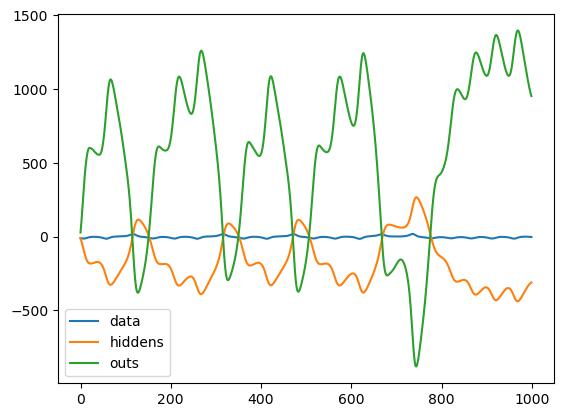

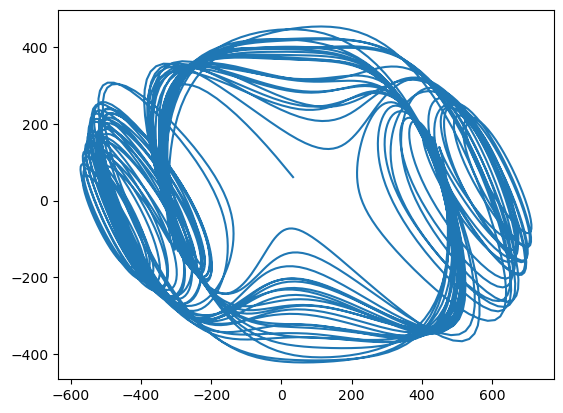

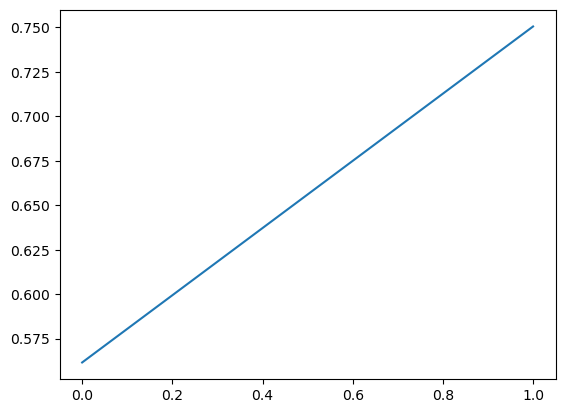

In [62]:
s4rnn = S4D_rnn(1,500)
data = torch.tensor(sol[np.newaxis,:,:1]).float().cpu()
data = data.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
print(data.size())

outs, hiddens = s4rnn(data)
plt.plot(data[0,0,:1000],label="data")
plt.plot(hiddens[0,:1000,0,0].detach().numpy(),label="hiddens")
plt.plot(outs[0,:1000,0].detach().numpy(),label="outs")
plt.legend()
print(hiddens.shape,outs.shape)

hidden = hiddens.squeeze().detach().numpy().real
print(hidden.shape)
pca = PCA(n_components=2)
pca.fit(hidden)
hidden_pca = pca.transform(hidden)
plt.figure()
plt.plot(hidden_pca[:,0],hidden_pca[:,1],label="reconstructed w PCA")
plt.figure()
#plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [77]:
class OfficialS4Minimal(nn.Module):
    def __init__(self,d_input,d_output,d_model,d_state,dropout=0.0,prenorm=False,diagonal=True,rnn=False):
        super().__init__()
        self.prenorm = prenorm
        self.encoder = nn.Linear(d_input,d_model)
        s4 = S4 if not diagonal else S4D
        if rnn:
            s4 = S4D_rnn

        self.s4 = s4(d_model,d_state=d_state)

        self.decoder = nn.Linear(d_model,d_output)
        self.norm = nn.LayerNorm(d_model)

        self.mlp = nn.Sequential(
            nn.Linear(d_model,4*d_model),
            nn.ReLU(),
            nn.Linear(4*d_model,d_output)
        )

    def forward(self,x):
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)

        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)

        z = x
        if self.prenorm:
            # Prenorm
            z = self.norm(z.transpose(-1, -2)).transpose(-1, -2)

        # Apply S4 block: we ignore the state input and output
        z, _ = self.s4(z)
        print(z.shape, x.shape)

        z = z.transpose(-1, -2)  # (B, d_model, L) -> (B, L, d_model)

        # Residual connection
        x = z + x

        if not self.prenorm:
            # Postnorm
            x = self.norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)

        # Decode the outputs
        x = self.mlp(x)  # (B, d_model) -> (B, d_output)

        return x, None




In [85]:
model = OfficialS4Minimal(1,1,1,500,rnn=True)

torch.Size([1, 5000, 1])
torch.Size([1, 5000, 1]) torch.Size([1, 1, 5000])
torch.Size([1, 5000, 1]) (5000, 250)


/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


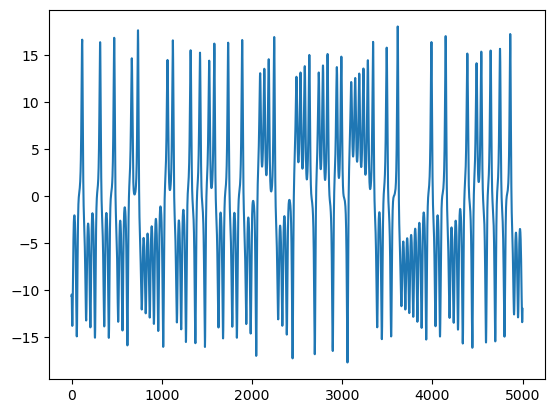

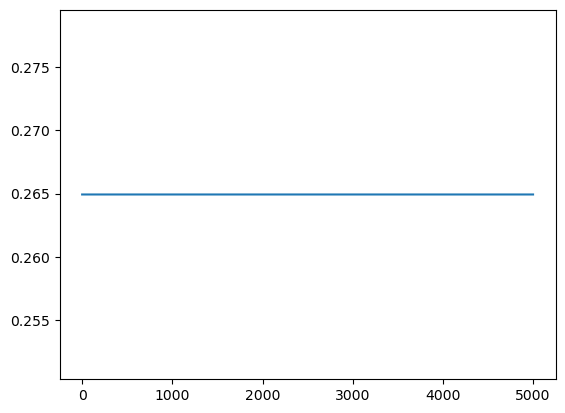

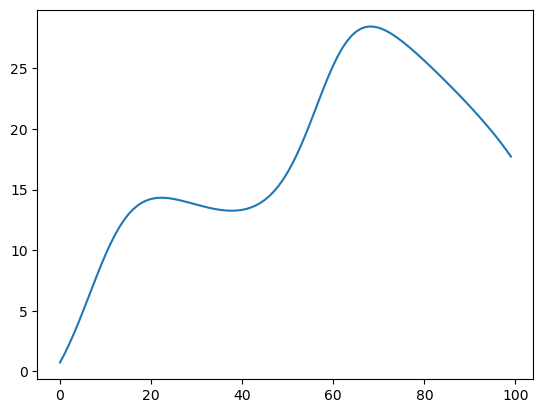

In [86]:
data = torch.tensor(sol[np.newaxis,:,:1]).float()
print(data.size())
plt.figure()
plt.plot(data[0,:,0])


out,_ = model(data)
hidden = model.s4.hiddens.detach().numpy().squeeze()
print(out.shape, hidden.shape)
plt.figure()
plt.plot(out.detach().numpy()[0,:,0])

plt.figure()
plt.plot(hidden[:100,0])

(5000, 250)


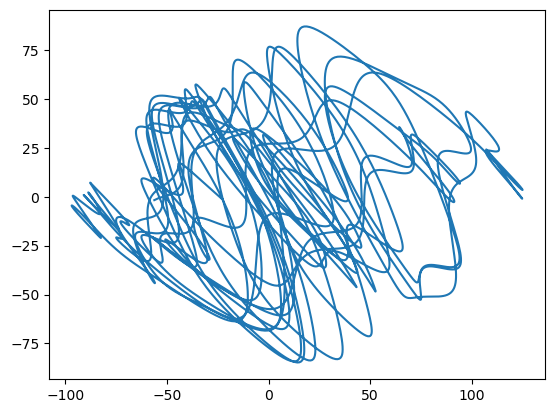

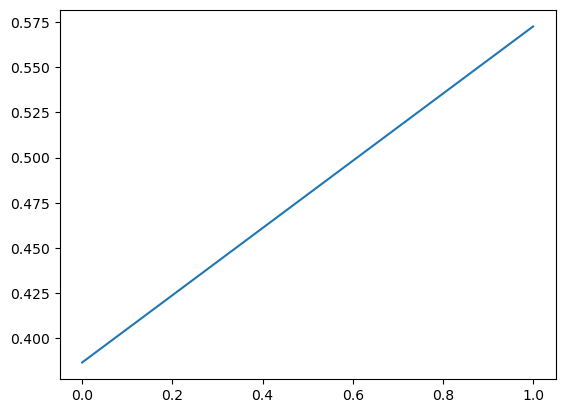

In [88]:
#run pca on the hidden states
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
print(hidden.shape)
hidden_pca = pca.fit_transform(hidden.real)
plt.figure()
plt.plot(hidden_pca[:,0],hidden_pca[:,1])
plt.figure()
#plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [89]:
from utils import make_dataset,train

train_loader, val_loader, train_data, val_data = make_dataset(Lorenz,2000,10)


(10, 2000, 3) torch.Size([10, 2000, 1])
(10, 2000, 3) torch.Size([10, 2000, 1])


In [91]:
from torch.optim import AdamW

model = OfficialS4Minimal(1,1,1,1000,dropout=0.1,prenorm=True,diagonal=True,rnn=True)

#model,train_set,val_set,epochs,lr,optimizer,loss_fn,device
all_train_loss = []
all_val_loss = []
for num_steps in [1,3]:
    model, train_loss, val_loss = train(model, train_loader, val_loader, 50, 1e-2,AdamW, nn.MSELoss(), 'cuda',num_steps)
    model, train_loss, val_loss = train(model, train_loader, val_loader, 50, 1e-3,AdamW, nn.MSELoss(), 'cuda',num_steps)
    all_train_loss.extend(train_loss)
    all_val_loss.extend(val_loss)

plt.plot(all_train_loss)
plt.plot(all_val_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 0 Training Loss: 58.09368133544922
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])


  2%|▏         | 1/50 [00:29<23:58, 29.36s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 0 Validation Loss: 55.85929985046387
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 1 Training Loss: 50.81689376831055
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1

  4%|▍         | 2/50 [00:55<22:03, 27.57s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 1 Validation Loss: 47.83227386474609
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 2 Training Loss: 43.24261245727539
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1

  6%|▌         | 3/50 [01:22<21:09, 27.02s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 2 Validation Loss: 38.916954040527344
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 3 Training Loss: 30.893732452392577
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1,

  8%|▊         | 4/50 [01:48<20:37, 26.90s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 3 Validation Loss: 21.443257904052736
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 4 Training Loss: 12.850558614730835
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1,

 10%|█         | 5/50 [02:15<20:14, 26.99s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 4 Validation Loss: 4.439219045639038
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 5 Training Loss: 1.6311544835567475
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 

 12%|█▏        | 6/50 [02:42<19:47, 26.98s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 5 Validation Loss: 1.2065389633178711
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 6 Training Loss: 1.757297945022583
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 

 14%|█▍        | 7/50 [03:09<19:16, 26.89s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 6 Validation Loss: 1.4043937802314759
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 7 Training Loss: 0.781348592042923
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 

 16%|█▌        | 8/50 [03:36<18:50, 26.91s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 7 Validation Loss: 0.5794589191675186
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 8 Training Loss: 0.6761667490005493
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1,

 18%|█▊        | 9/50 [04:03<18:25, 26.96s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 8 Validation Loss: 0.6309504747390747
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 9 Training Loss: 0.5800980359315873
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1,

 20%|██        | 10/50 [04:29<17:48, 26.72s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 9 Validation Loss: 0.5040475040674209
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 10 Training Loss: 0.5154631942510605
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1

 22%|██▏       | 11/50 [04:55<17:10, 26.41s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 10 Validation Loss: 0.5017480850219727
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 11 Training Loss: 0.5011769473552704
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([

 24%|██▍       | 12/50 [05:22<16:48, 26.55s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 11 Validation Loss: 0.4790790319442749
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 12 Training Loss: 0.4918580323457718
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([

 26%|██▌       | 13/50 [05:49<16:27, 26.70s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 12 Validation Loss: 0.47346688210964205
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 13 Training Loss: 0.4862954348325729
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size(

 28%|██▊       | 14/50 [06:15<15:59, 26.65s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 13 Validation Loss: 0.4681973785161972
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 14 Training Loss: 0.48056253492832185
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size(

 30%|███       | 15/50 [06:41<15:22, 26.35s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 14 Validation Loss: 0.46249266266822814
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 15 Training Loss: 0.47660268247127535
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size

 32%|███▏      | 16/50 [07:08<15:01, 26.51s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 15 Validation Loss: 0.4605319410562515
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 16 Training Loss: 0.4743355005979538
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([

 34%|███▍      | 17/50 [07:35<14:39, 26.66s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 16 Validation Loss: 0.4555149734020233
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 17 Training Loss: 0.46854729056358335
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size(

 36%|███▌      | 18/50 [08:01<14:09, 26.54s/it]

torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
Epoch 17 Validation Loss: 0.4503442347049713
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])
torch.Size([1, 1999, 1]) torch.Size([1, 1, 1999])


 36%|███▌      | 18/50 [08:06<14:24, 27.01s/it]
/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/einops/einops.py:827: SyntaxWarning: invalid escape sequence '\s'
  """


KeyboardInterrupt: 

torch.Size([1, 5000, 1])
torch.Size([1, 5000, 1]) torch.Size([1, 1, 5000])
torch.Size([1, 5000, 1]) (5000, 500)
(5000, 500)


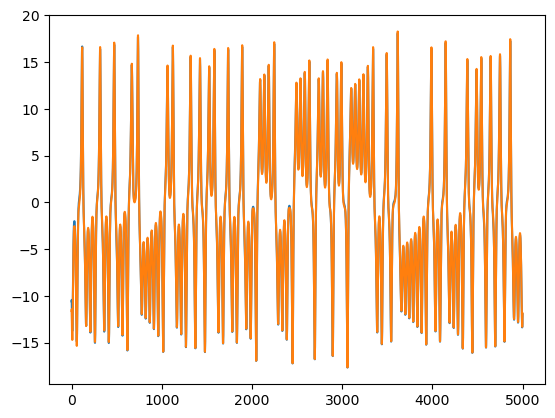

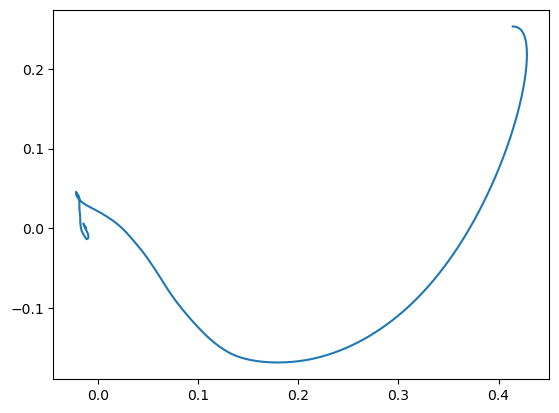

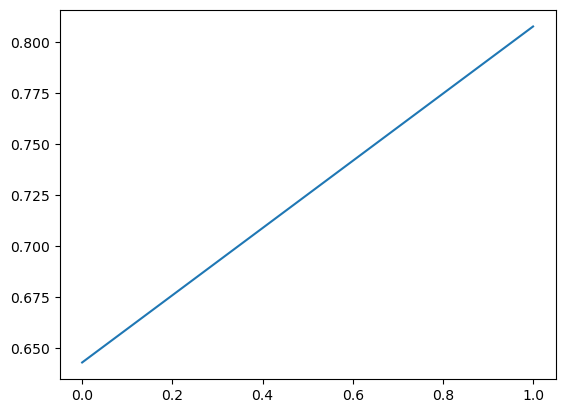

In [93]:
data = torch.tensor(sol[np.newaxis,:,:1]).float().cuda()
print(data.size())
plt.figure()
plt.plot(data[0,:,0].cpu())


out,_ = model(data)
hidden = model.s4.hiddens.detach().cpu().numpy().squeeze()
print(out.shape, hidden.shape)
plt.plot(out.detach().cpu().numpy()[0,:,0])

#run pca on the hidden states
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
print(hidden.shape)
hidden_pca = pca.fit_transform(hidden.real)
plt.figure()
plt.plot(hidden_pca[:,0],hidden_pca[:,1])
plt.figure()
#plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
def hippo_initializer(dim):
    pass

def discretize_dplr(lambd,P,Q,B,C,step,l_max):
    pass

def scan_ssm(ssm,u,x0):
    pass

class minimalS4(nn.Module):
    def __init__(self, input_dim,d_model,n_head):
        super().__init__()

        
